In [1]:
import numpy as np
import pathlib
import math
import tqdm
import scipy.io
from matplotlib import pyplot as plt
import scipy.io
import h5py
import re
from lxml import etree as ET
import scipy.signal as sig
import pandas as pd
from scipy.stats import kde
from BlockSync_current import BlockSync
import UtilityFunctions_newOE as uf

In [2]:
# define a single block to figure things out with:
# this step creates block_collection - a list of BlockSync objects of interest
block_numbers = range(23,33)
bad_blocks = [42, 61, 62, 64, 65, 66]
experiment_path = pathlib.Path(r"Z:\Nimrod\experiments")
animal = 'PV_62'
block_collection = uf.block_generator(block_numbers=block_numbers,
                                      experiment_path=experiment_path,
                                      animal=animal,
                                      bad_blocks=bad_blocks)
# create a block_dict object for ease of access:
block_dict = {}
for b in block_collection:
    block_dict[str(b.block_num)] = b



instantiated block number 023 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_023, new OE version
Found the sample rate for block 023 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 023
got it!
instantiated block number 024 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_024, new OE version
Found the sample rate for block 024 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 024
got it!
instantiated block number 025 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_025, new OE version
Found the sample rate for block 025 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 025
got it!
instantiated block number 026 at Path: Z:\Nimrod\experi

In [38]:
# This step is used to quickly go over the analyzed blocks and load their internal data
for block in block_collection:
    block.parse_open_ephys_events()
    block.get_eye_brightness_vectors()
    block.synchronize_block()
    block.create_eye_brightness_df(threshold_value=20)

running parse_open_ephys_events...
block 023 has a parsed events file, reading...
getting eye brigtness values for block 023...
found a file!
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
running parse_open_ephys_events...
block 024 has a parsed events file, reading...
getting eye brigtness values for block 024...
found a file!
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
running parse_open_ephys_events...
block 025 has a parsed events file, reading...
getting eye brigtness values for block 025...
found a file!
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
running parse_open_ephys_events...
block 026 has a parsed events file, reading...
getting eye brigtness values for block 026...
found a file!
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
running parse_open_ephys_events...
block 027 has a parsed events file, reading...
ge

In [39]:
# This is a continuation of the previous - more data loadings
for block in block_collection:
    block.import_manual_sync_df()
    block.read_dlc_data()

eye dataframes loaded from analysis folder
eye dataframes loaded from analysis folder
eye dataframes loaded from analysis folder
eye dataframes loaded from analysis folder
eye dataframes loaded from analysis folder
eye dataframes loaded from analysis folder
eye dataframes loaded from analysis folder
eye dataframes loaded from analysis folder
eye dataframes loaded from analysis folder
eye dataframes loaded from analysis folder


In [40]:
"""
This function cascades over the steps that end in two dataframe objects, one for synced saccades and the other
        non-synced saccades. This function requires completion of all previous analysis steps (in particular, lizMov.mat
        should be produced using mark's code)
"""
for block in block_collection:
    print(block)
    block.saccade_dict_creation_3d(sampling_window_ms=2000,
                                ep_channel_number=5,
                                automate_saccade_detection=True,
                                overwrite_saccade_data=False)

PV_62, block 023, on 2023-04-27_10-52-42
path to mat file is Z:\Nimrod\experiments\PV_62\2023_04_27\block_023\oe_files\2023-04-27_10-52-42\Record Node 108\analysis\recNames=Block0023,Animal=PV_62\lizMov.mat
loaded chunked saccade data from analysis folder
getting data with block_number 023: 
There are 556 saccade events: 
pre_saccade_ts = [  38430.     39126.35   39364.1    40587.     46717.75   48246.2
   50046.4    50199.3    50555.9    51116.35   51218.3    51371.1
   51710.7    53545.     53697.85   53833.75   54428.15   54581.
   55073.55   56041.65   59591.1    62800.5    65500.9    72633.85
   81686.8    86561.65   86833.4    88039.25   88158.15   88260.05
   88446.9    88514.8    88599.7    88752.6    88939.4    89007.35
   89414.9    91130.15   91571.7    92081.15   92488.75   92590.65
   93338.05   94000.35   95222.95   96394.7    98483.5    98840.2
   99111.9    99791.25  101183.75  103153.8   110796.55  115909.
  116724.35  119646.15  119833.    120240.65  121531.2   121633

In [41]:
# This cell sorts the saccade data from the BlockSync objects into dataframes
block_sync_dfs = [block.synced_saccades_df for block in block_collection]
stacked_synced_df = pd.concat(block_sync_dfs, ignore_index=True)
block_non_synced_dfs = [block.non_synced_saccades_df for block in block_collection]
stacked_non_synced_df = pd.concat(block_non_synced_dfs, ignore_index=True)

,datetime,block,eye,timestamps,fs,pxx,samples,x_coords,y_coords,vid_inds,x_speed,y_speed,magnitude,dx,dy,direction,accel,calib_dx,calib_dy
0,2023-04-27_10-52-42,023,L,38430,"[0.0, 1.220703125, 2.44140625, 3.662109375, 4....","[21.230001477120823, 132.57830316922525, 154.1...","[15.21, 6.63, -1.56, 11.31, -14.04000000000000...","[-2.722385320513065, -2.7220221226769814, -2.7...","[2.088379138952184, 2.088766117332091, 2.08835...","[0, 340, 680, 1020, 1359, 1699, 2039, 2378, 27...","[0.0, 0.00036319783608362854, -0.0025278362611...","[0.0, 0.00038697837990664397, -0.0004070591155...",0.062496,-0.0217268,-0.0585977,249.656,0,-0.00120747,-0.00325658
1,2023-04-27_10-52-42,023,L,39126.3,"[0.0, 1.220703125, 2.44140625, 3.662109375, 4....","[172.56771367747237, 513.301973360828, 312.630...","[-43.485, -19.305, -7.0200000000000005, -32.76...","[-2.722385320513065, -2.7220221226769814, -2.7...","[2.088379138952184, 2.088766117332091, 2.08835...","[0, 340, 680, 1020, 1359, 1699, 2039, 2378, 27...","[0.0, 0.00036319783608362854, -0.0025278362611...","[0.0, 0.00038697837990664397, -0.0004070591155...",0.062496,-0.0217268,-0.0585977,249.656,0,-0.00120747,-0.00325658
2,2023-04-27_10-52-42,023,L,39364.1,"[0.0, 1.220703125, 2.44140625, 3.662109375, 4....","[50.252659001191205, 550.345529481624, 402.680...","[-28.470000000000002, -23.400000000000002, -21...","[-2.722385320513065, -2.7220221226769814, -2.7...","[2.088379138952184, 2.088766117332091, 2.08835...","[0, 340, 680, 1020, 1359, 1699, 2039, 2378, 27...","[0.0, 0.00036319783608362854, -0.0025278362611...","[0.0, 0.00038697837990664397, -0.0004070591155...",0.062496,-0.0217268,-0.0585977,249.656,0,-0.00120747,-0.00325658
3,2023-04-27_10-52-42,023,L,40587,"[0.0, 1.220703125, 2.44140625, 3.662109375, 4....","[13.944797937505369, 74.85746732506726, 70.534...","[25.35, 5.655, -21.45, -14.43, 16.575, 4.485, ...","[-2.7374948097032714, -2.737752235247159, -2.7...","[2.059583754348824, 2.059335306010424, 2.05937...","[0, 339, 679, 1019, 1358, 1698, 2038, 2377, 27...","[0.0, -0.00025742554388763494, -0.000182974860...","[0.0, -0.0002484483383997649, 4.44715793452843...",0.0527638,-0.0474871,0.0229997,115.843,0,-0.00263911,0.00127822
4,2023-04-27_10-52-42,023,L,46717.8,"[0.0, 1.220703125, 2.44140625, 3.662109375, 4....","[3.109451401947336, 246.72568950784057, 482.27...","[-43.875, -56.160000000000004, -76.44, -86.385...","[-2.75391353911953, -2.753773404838437, -2.753...","[2.1002903792305267, 2.1005818956631868, 2.100...","[0, 340, 680, 1020, 1359, 1699, 2038, 2379, 27...","[0.0, 0.00014013428109338477, 5.30511966982949...","[0.0, 0.0002915164326600106, 1.518807184464066...",0.0288388,0.0118709,0.0262823,65.6927,0,0.000659731,0.00146065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7081,2023-04-27_15-51-55,032,R,1.43162e+06,"[0.0, 1.220703125, 2.44140625, 3.662109375, 4....","[1.8424144763194203, 74.24548593129214, 241.40...","[-16.77, -33.15, -10.725, -6.4350000000000005,...","[-2.304644720162237, -2.3046186420997925, -2.3...","[1.4527855099155866, 1.452782476734059, 1.4527...","[0, 340, 679, 1019, 1359, 1698, 2038, 2378, 27...","[0.0, 2.607806244458999e-05, 2.60780624441459e...","[0.0, -3.033181527722917e-06, -3.0331815279449...",0.12871,0.121488,-0.0425093,289.285,5.76173e+06,0.00469022,-0.00164114
7082,2023-04-27_15-51-55,032,R,1.43191e+06,"[0.0, 1.220703125, 2.44140625, 3.662109375, 4....","[5.427342927566343, 83.16483222199986, 120.093...","[14.43, 19.89, 21.84, 13.065000000000001, 17.1...","[-2.3248061252189864, -2.3226697080304533, -2....","[1.4419371712033684, 1.4414615685783971, 1.441...","[0, 340, 679, 1019, 1359, 1698, 2038, 2378, 27...","[0.0, 0.0021364171885331906, 0.000389464046546...","[0.0, -0.0004756026249712608, -0.0003479067471...",0.142341,0.138775,-0.031661,282.852,6.95666e+06,0.00535762,-0.00122232
7083,2023-04-27_15-51-55,032,R,1.43208e+06,"[0.0, 1.220703125, 2.44140625, 3.662109375, 4....","[19.911289169245737, 75.38475255493682, 103.67.

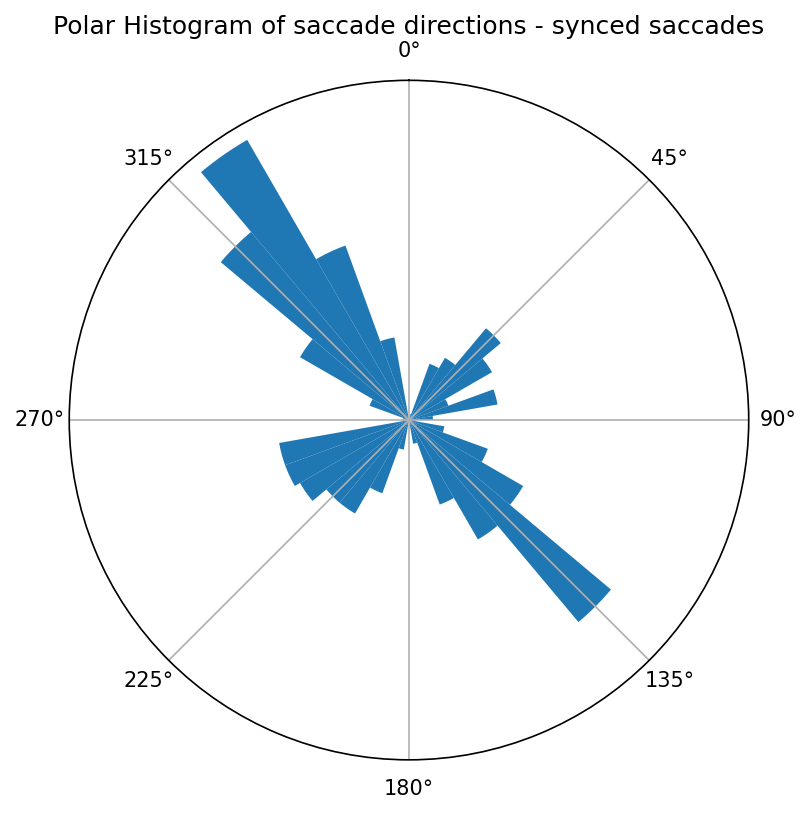

In [76]:
# Saccade direction histogram:
vals = stacked_synced_df.query('block == "023" and eye == "L"').direction.values # synced saccades
num_bins = 36
hist, bin_edges = np.histogram(vals, bins=num_bins, range=(0, 360))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers

plt.figure(figsize=(8, 6), dpi=150)
ax = plt.subplot(111, projection='polar')

ax.bar(np.deg2rad(list(bin_centers.astype(int))), hist, width=np.deg2rad(360/num_bins), align='center')

ax.set_theta_direction(-1)
ax.set_theta_offset(np.radians(90))
ax.grid(True)
#ax.set_rlabel_position(0)
ax.set_yticks([])
plt.title("Polar Histogram of saccade directions - synced saccades")

plt.show()

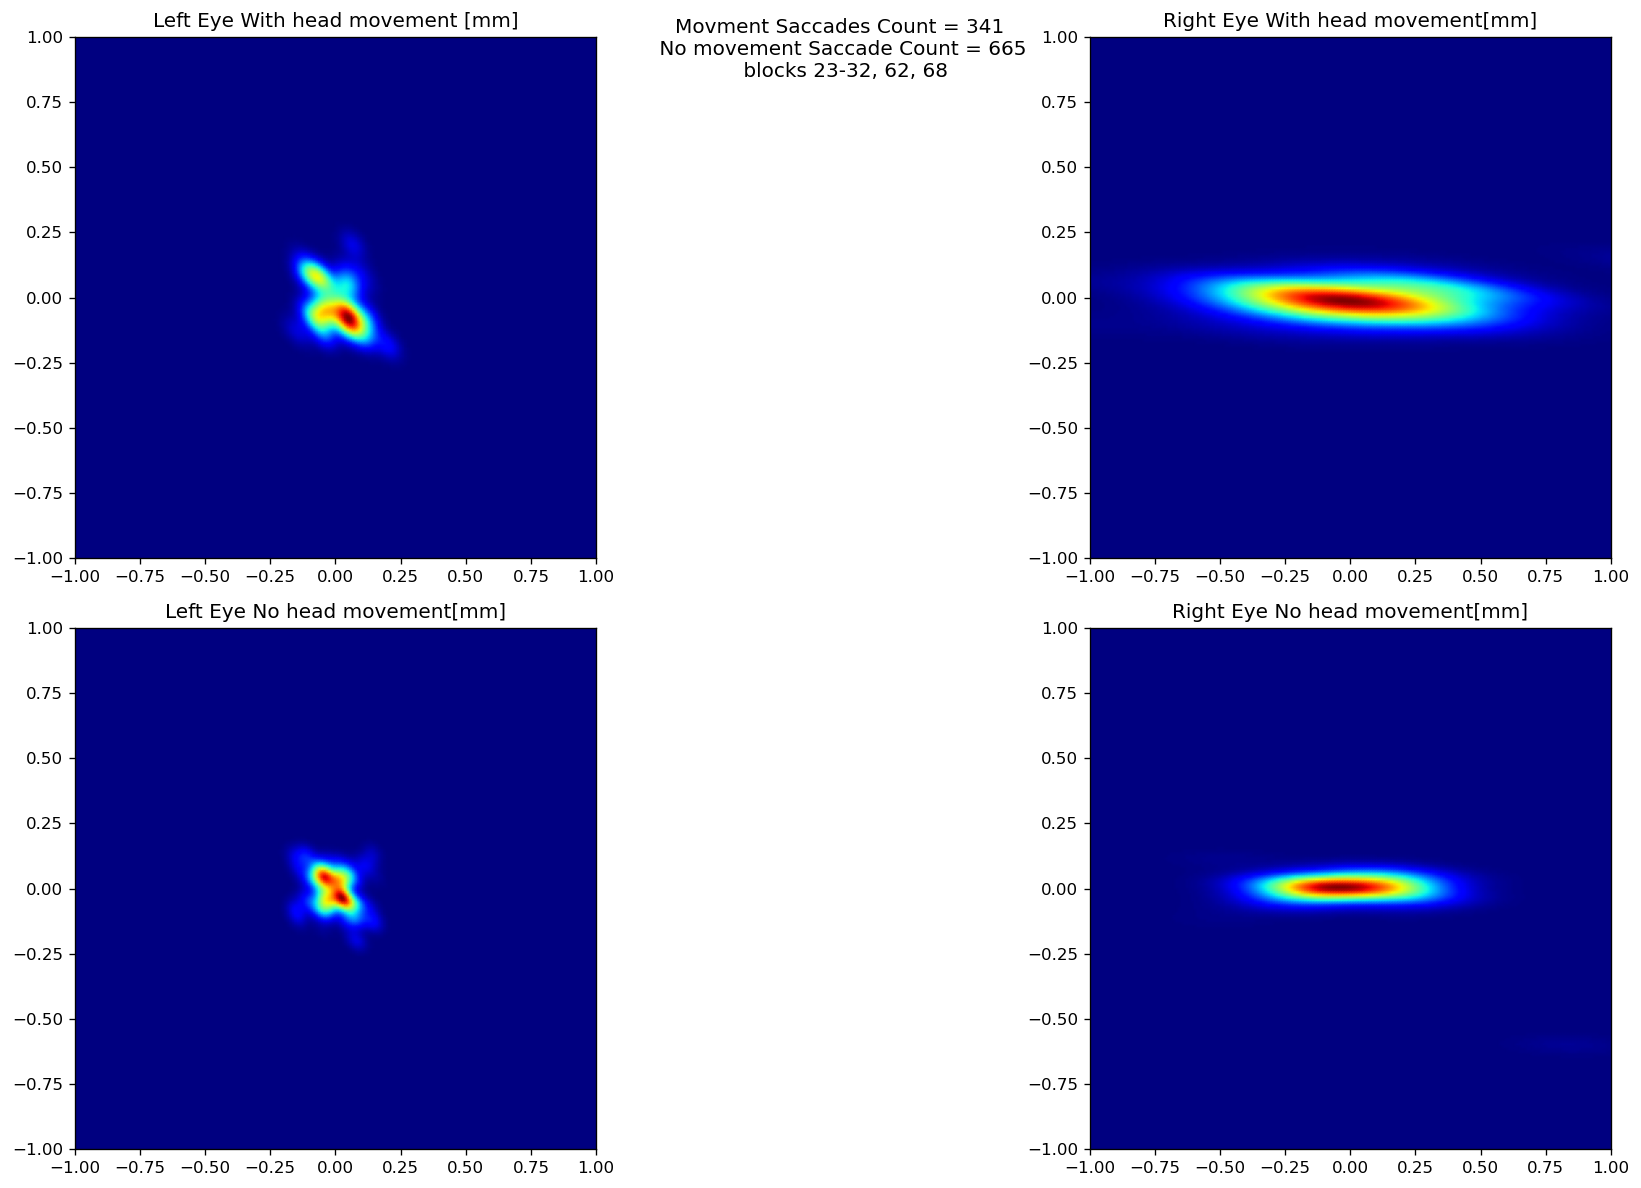

In [51]:
# this cell creates the synced saccades heatmap:

# I can now query the data I want to analyze, let's take all the 0 accel magnitude saccades:
no_accel_df = stacked_synced_df.query("accel == 0 and block == '023'")
all_accel_df = stacked_synced_df.query("accel != 0 and block == '023'")

# I can produce the KDE graphs for them:
# parse queries:
la_x = all_accel_df.query('eye == "L"')['dx']
la_y = all_accel_df.query('eye == "L"')['dy']
ra_y = all_accel_df.query('eye == "R"')['dy']
ra_x = all_accel_df.query('eye == "R"')['dx']

ln_x = no_accel_df.query('eye == "L"')['dx']
ln_y = no_accel_df.query('eye == "L"')['dy']
rn_y = no_accel_df.query('eye == "R"')['dy']
rn_x = no_accel_df.query('eye == "R"')['dx']

#understand graph bounderies:
x_stack = np.concatenate([la_x,ra_x,ln_x,rn_x])
y_stack = np.concatenate([la_y,ra_y,ln_y,rn_y])
global_max = np.max(np.concatenate([x_stack,y_stack]))
global_min = np.min(np.concatenate([x_stack,y_stack]))

#xlim = (np.min(x_stack), np.max(x_stack))
#ylim = (np.min(y_stack), np.max(y_stack))
global_max = 1
global_min = -1
# create the graph
fig, axes = plt.subplots(ncols=2, nrows=2, figsize =(10*2,5*2), dpi=120)
uf.plot_kde(axes[0,0],la_x,la_y,200,'Left Eye With head movement [mm]',global_max=global_max,global_min=global_min)
uf.plot_kde(axes[0,1],ra_x,ra_y,200,'Right Eye With head movement[mm]',global_max=global_max,global_min=global_min)
uf.plot_kde(axes[1,0],ln_x,ln_y,200,'Left Eye No head movement[mm]',global_max=global_max,global_min=global_min)
uf.plot_kde(axes[1,1],rn_x,rn_y,200,'Right Eye No head movement[mm]',global_max=global_max,global_min=global_min)
fig.suptitle(f"Movment Saccades Count = {len(all_accel_df)} \n No movement Saccade Count = {len(no_accel_df)} \n blocks 23-32, 62, 68")
fig.tight_layout()
# Save the figure as a PDF
output_path = r"D:\MarkS3\Pictures\Graphs\PV_62\graphs_for_paper_iteration_1\synced_saccade_heatmap_blocks_23to32_62_68.pdf"
plt.savefig(output_path, bbox_inches='tight', format='pdf')

Below are code snippets used for testing the class modifications for 3d based angle calculation results

In [22]:
block = block_collection[1]

In [23]:
block.parse_open_ephys_events()
block.get_eye_brightness_vectors()
block.synchronize_block()
block.create_eye_brightness_df(threshold_value=20)


running parse_open_ephys_events...
block 024 has a parsed events file, reading...
getting eye brigtness values for block 024...
found a file!
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder


,Arena_TTL,Arena_frame,L_eye_frame,R_eye_frame,L_values,R_values
0,605092.0,812.0,3.0,1.0,-2.813021,0.885172
1,605431.0,813.0,4.0,2.0,-2.812300,0.887300
2,605771.0,814.0,5.0,3.0,-2.813676,0.890668
3,606111.0,815.0,6.0,4.0,-2.811976,0.892202
4,606451.0,816.0,7.0,5.0,-2.811819,0.893261
...,...,...,...,...,...,...
91948,31841220.0,92760.0,93882.0,93880.0,-1.849970,1.670915
91949,31841560.0,92761.0,93883.0,93881.0,-1.849450,1.670836
91950,31841900.0,92762.0,93884.0,93882.0,-1.847996,1.670840
91951,31842239.0,92763.0,93885.0,93883.0,-1.852570,1.670417


In [24]:
block.import_manual_sync_df()
block.read_dlc_data()

eye dataframes loaded from analysis folder


In [25]:
block.saccade_dict_creation_3d(sampling_window_ms=2000,
                               ep_channel_number=15,
                               automate_saccade_detection=True,
                               overwrite_saccade_data=False)

path to mat file is Z:\Nimrod\experiments\PV_62\2023_04_27\block_024\oe_files\2023-04-27_11-22-56\Record Node 108\analysis\recNames=Block0024,Animal=PV_62\lizMov.mat
loaded chunked saccade data from analysis folder
getting data with block_number 024: 
There are 446 saccade events: 
pre_saccade_ts = [  31734.45   35879.35   37442.     37510.     38631.35   38767.3
   38971.2    41825.1    47956.75   59678.4    66354.2    70125.8
   71994.7    78246.2    80794.35   83970.8    85363.85   94317.55
  100570.1   100723.    100943.85  101028.8   103016.05  103763.3
  104001.1   104612.55  104680.5   105207.05  106022.25  106243.1
  110269.35  110405.25  110490.25  112341.95  130028.25  130639.9
  130707.85  130894.75  130962.7   131387.4   131659.2   132083.85
  132559.5   133612.8   136415.35  136585.2   136806.05  140882.65
  141409.35  142547.65  142615.6   144535.55  147203.05  150074.15
  153080.85  157549.    163189.8   167233.6   167335.55  168066.2
  168134.15  169323.5   172688.05  1

In [26]:
block.synced_saccades_df

,datetime,block,eye,timestamps,fs,pxx,samples,x_coords,y_coords,vid_inds,x_speed,y_speed,magnitude,dx,dy,direction,accel,calib_dx,calib_dy
0,2023-04-27_11-22-56,024,L,35879.3,"[0.0, 1.220703125, 2.44140625, 3.662109375, 4....","[28.461789749877124, 219.61683396318813, 129.9...","[31.785, 42.9, 37.245000000000005, 34.71, 42.3...","[-2.8280452983025515, -2.8285249601372824, -2....","[2.301520336091909, 2.3009702158120238, 2.3009...","[0, 340, 680, 1019, 1359, 1699, 2039, 2378, 27...","[0.0, -0.0004796618347309156, -0.0002301215670...","[0.0, -0.0005501202798852134, -2.3826542723259...",0.101465,0.0724547,-0.0710309,314.431,0,0.00352654,-0.00345724
1,2023-04-27_11-22-56,024,L,37442,"[0.0, 1.220703125, 2.44140625, 3.662109375, 4....","[9.148952843273662, 223.3684317098998, 384.974...","[-23.01, -9.945, -4.485, -10.335, 2.145, -23.2...","[-2.7682226138024344, -2.7686187086267835, -2....","[2.2561192790472018, 2.256031652186565, 2.2559...","[0, 339, 679, 1019, 1359, 1698, 2038, 2378, 27...","[0.0, -0.0003960948243491025, -6.0550710703211...","[0.0, -8.762686063690239e-05, -3.6321865021005...",0.0595318,0.0384071,-0.0454855,319.823,9.12184e+06,0.00186936,-0.00221388
2,2023-04-27_11-22-56,024,L,37510,"[0.0, 1.220703125, 2.44140625, 3.662109375, 4....","[15.05675867808143, 244.40372958206044, 416.48...","[23.79, 31.200000000000003, 30.810000000000002...","[-2.7689323041484237, -2.7691358413403044, -2....","[2.256648881119588, 2.25647250205512, 2.256668...","[0, 339, 679, 1019, 1359, 1698, 2038, 2378, 27...","[0.0, -0.0002035371918807094, -0.0001144216096...","[0.0, -0.0001763790644679908, 0.00019595354536...",0.0595318,0.0384071,-0.0454855,319.823,9.12184e+06,0.00186936,-0.00221388
3,2023-04-27_11-22-56,024,L,38631.3,"[0.0, 1.220703125, 2.44140625, 3.662109375, 4....","[55.28544391696249, 150.48462909926783, 462.22...","[17.16, 30.225, 15.21, 21.84, -5.655, -4.485, ...","[-2.7405729062779747, -2.7404197945465363, -2....","[2.2359792736640114, 2.2367093650133216, 2.237...","[0, 339, 679, 1019, 1359, 1699, 2038, 2378, 27...","[0.0, 0.0001531117314383934, 0.000559068305554...","[0.0, 0.0007300913493102357, 0.000623284811891...",0.0857152,-0.0289464,-0.0806797,250.263,7.79418e+06,-0.00140889,-0.00392687
4,2023-04-27_11-22-56,024,L,38767.3,"[0.0, 1.220703125, 2.44140625, 3.662109375, 4....","[23.263085867796736, 116.24975317446952, 408.3...","[5.46, 6.24, 1.56, -6.825, -20.28, -13.0650000...","[-2.741539308689728, -2.7415177014480427, -2.7...","[2.241332649499605, 2.242416278566696, 2.24279...","[0, 340, 680, 1019, 1359, 1699, 2038, 2378, 27...","[0.0, 2.1607241685206446e-05, -0.0005389519005...","[0.0, 0.0010836290670908078, 0.000375455515770...",0.0858763,-0.0294198,-0.0806797,249.966,7.79418e+06,-0.00143193,-0.00392687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
769,2023-04-27_11-22-56,024,R,1.57917e+06,"[0.0, 1.220703125, 2.44140625, 3.662109375, 4....","[11.186309362937843, 260.93928495561926, 904.4...","[8.385, 37.635, 37.44, 41.730000000000004, 50....","[-2.168759673930511, -2.16826387550789, -2.167...","[1.365135954552796, 1.3650840434900322, 1.3650...","[0, 340, 679, 1019, 1359, 1698, 2038, 2378, 27...","[0.0, 0.0004957984226212631, 0.001025588865836...","[0.0, -5.191106276369872e-05, -8.2033740537168...",0.209087,0.20667,0.0316968,8.71946,2.99353e+06,0.0109044,0.00167241
770,2023-04-27_11-22-56,024,R,1.57951e+06,"[0.0, 1.220703125, 2.44140625, 3.662109375, 4....","[46.753995478463885, 317.13443422916936, 1064....","[-40.365, -7.995, -20.475, -20.475, -15.21, -2...","[-2.1528788000824903, -2.151660261133946, -2.1...","[1.3632503202263913, 1.3629890297755192, 1.363...","[0, 339, 679, 1019, 1359, 1699, 2038, 2379, 27...","[0.0, 0.0012185389485441789, -0.00068095944860...","[0.0, -0.000261290450872087, 4.716814555605353...",0.209087,0.20667,0.0316968,8.71946,2.99353e+06,0.0109044,0.00167241
771,2023-04-27_11-22-56,024,R,1.58204e+06,"[0.0, 1.220703125, 2.44140625, 3.662109375, 4....","[17.55967285239

In [27]:
# get the left eye saccades, but with the 3D approximations:
l_eye_saccade_start_times = block.synced_saccades_df.query('eye=="L"').timestamps.values + 1000

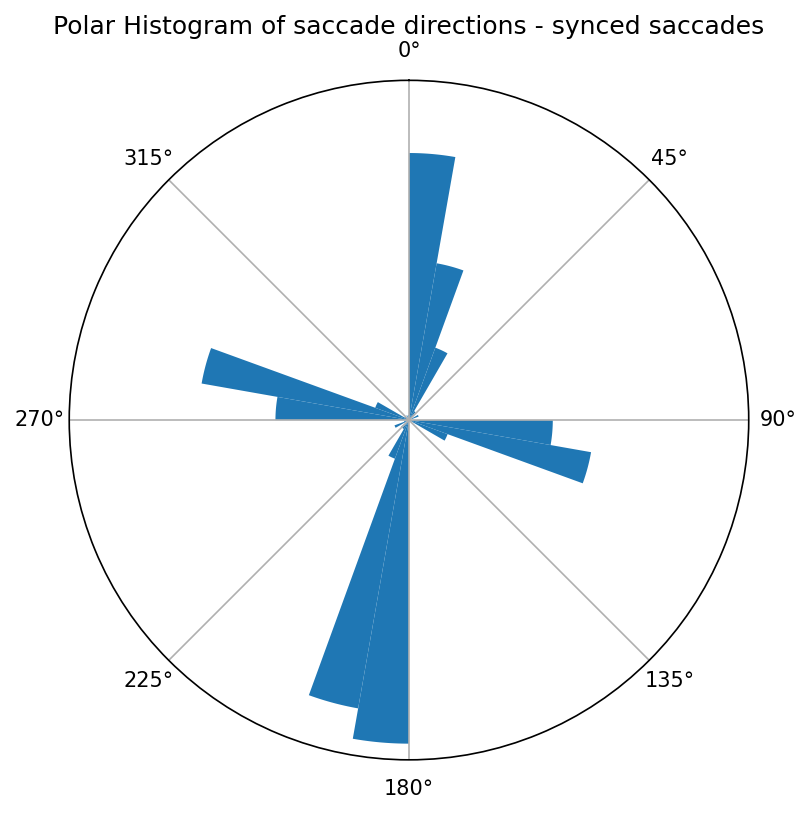

In [36]:
vals = block.synced_saccades_df.query("eye=='R'").direction # synced saccades
num_bins = 36
hist, bin_edges = np.histogram(vals, bins=num_bins, range=(0, 360))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers

plt.figure(figsize=(8, 6), dpi=150)
ax = plt.subplot(111, projection='polar')

ax.bar(np.deg2rad(list(bin_centers.astype(int))), hist, width=np.deg2rad(360/num_bins), align='center')

ax.set_theta_direction(-1)
ax.set_theta_offset(np.radians(90))
ax.grid(True)
#ax.set_rlabel_position(0)
ax.set_yticks([])
plt.title("Polar Histogram of saccade directions - synced saccades")

plt.show()

In [30]:
block.re_df

,Unnamed: 0.1,Arena_TTL,R_eye_frame,L_values,R_values,center_x,center_y,width,height,phi,ellipse_size,ms_axis,theta,phi_3d,velocity
0,0,605092.0,1.0,NaN,0.885172,310.409134,250.277613,47.800509,33.395239,-0.264672,5014.954025,30254.60,2.164455,-2.949296,397.332783
1,1,605431.0,2.0,NaN,0.887300,310.399686,250.378361,47.680992,33.392232,-0.260285,5001.964438,30271.55,2.164266,-2.949522,0.101190
2,2,605771.0,3.0,NaN,0.890668,310.471220,250.245759,47.721889,33.429210,-0.263557,5011.798682,30288.55,2.164623,-2.949408,0.150666
3,3,606111.0,4.0,NaN,0.892202,310.620853,250.489148,47.621539,33.497249,-0.274897,5011.438944,30305.55,2.164400,-2.950047,0.285706
4,4,606451.0,5.0,-2.813021,0.893261,310.466090,250.360016,47.783707,33.418256,-0.264332,5016.646443,30322.55,2.164387,-2.949506,0.201561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91948,91948,31841220.0,93880.0,-1.851355,1.670915,233.505053,259.966543,27.445934,44.464860,0.758888,3833.935590,1592061.00,1.420727,-2.096649,0.147166
91949,91949,31841560.0,93881.0,-1.855220,1.670836,233.418682,259.929727,27.411306,44.490861,0.760749,3831.337437,1592078.00,1.420692,-2.097660,0.093890
91950,91950,31841900.0,93882.0,-1.851100,1.670840,233.432912,259.815929,27.440051,44.461773,0.755164,3832.847697,1592095.00,1.420560,-2.098693,0.114684
91951,91951,31842239.0,93883.0,-1.852275,1.670417,233.458277,259.911139,27.601253,44.371037,0.759295,3847.496694,1592111.95,1.420704,-2.098522,0.098531


In [55]:
block = block_collection[0]
block

BlockSync object for animal PV_62 with 
block_num 023 at date 2023-04-27_10-52-42

In [65]:
le_df_3d = pd.read_csv(block.analysis_path / 'le_df_3d.csv',index_col=0)
le_df_3d = le_df_3d[['timestamp','diameter_3d','theta','phi']]
re_df_3d = pd.read_csv(block.analysis_path / 're_df_3d.csv',index_col=0)
re_df_3d = re_df_3d[['timestamp','diameter_3d','theta','phi']]

le_df_3d.head()


,timestamp,diameter_3d,theta,phi
0,39379.00,1.244536,2.088379,-2.722385
1,39396.00,1.238606,2.088766,-2.722022
2,39413.00,1.257631,2.088359,-2.724550
3,39430.00,1.284043,2.066025,-2.730719
4,39446.95,1.264909,2.047101,-2.731785


In [57]:
# start from interpolating over the dataframe:
le_df_3d.interpolate(method='linear',inplace=True)
re_df_3d.interpolate(method='linear',inplace=True)

# now get the angular_velocity measurement
angular_displacement_phi = le_df_3d['phi'].diff()
angular_displacement_theta = le_df_3d['theta'].diff()
angular_displacement = np.sqrt(angular_displacement_phi**2 + angular_displacement_theta**2)
le_df_3d['angular_displacement'] = angular_displacement
le_df_3d['delta_t'] = le_df_3d['timestamp'].diff()
le_df_3d['angular_velocity'] = le_df_3d['angular_displacement'] / le_df_3d['delta_t']
window_size= 11
le_df_3d['rolling_avg_angular_velocity'] = le_df_3d['angular_velocity'].rolling(window=window_size, center=True).mean()

In [33]:
from bokeh.plotting import figure, show
from bokeh.models import Span
import pandas as pd

# Sample data (replace with your actual data)
velocity_measurement = le_df_3d.angular_velocity.values
x_axis = le_df_3d.timestamp  # Keep x_axis as raw values
saccade_locations = l_eye_saccade_start_times

# Set the desired aspect ratio (7:15)
aspect_ratio = 7 / 15

# Calculate the plot width and height based on the aspect ratio
plot_width = 1800  # Adjust as needed
plot_height = int(plot_width * aspect_ratio)

# Create a Bokeh figure with the specified width and height
p = figure(
    title="Angular Velocity Measurement",
    x_axis_label="Raw X Axis",
    y_axis_label="Velocity",
    plot_width=plot_width,
    plot_height=plot_height,
)

# Line plot of velocity_measurement
p.line(x_axis, velocity_measurement, legend_label="Velocity", line_color="blue")

# Add vertical lines at saccade locations
for saccade_time in saccade_locations:
    saccade_line = Span(location=saccade_time, dimension="height", line_color="red", line_width=2, line_alpha=0.3)
    p.add_layout(saccade_line)

# Customize the plot further (e.g., add tooltips, adjust axis labels, etc.) as needed

# Show the Bokeh plot
show(p)


In [63]:
# This section used to sanity-check the 3D projection output
from bokeh.io import output as b_output
def block_verify_projection_real(block, le_3d, re_3d, export=False, ms_x_axis=True, plot_saccade_locs=False,
                   saccade_frames_l=None, saccade_frames_r=None):
    # normalize values:
    le_el_z = (block.le_df.ellipse_size - block.le_df.ellipse_size.mean()) / block.le_df.ellipse_size.std()
    le_x_z = (block.le_df.center_x - np.mean(block.le_df.center_x)) / block.le_df.center_x.std()
    le_y_z = (block.le_df.center_y - np.mean(block.le_df.center_y)) / block.le_df.center_y.std()
    le_theta_z = (le_df_3d.theta.values - np.nanmean(le_df_3d.theta.values)) / np.nanstd(le_df_3d.theta.values)
    le_phi_z = (le_df_3d.phi.values - np.nanmean(le_df_3d.phi.values)) / np.nanstd(le_df_3d.phi.values)
    re_theta_z = (re_df_3d.theta.values - np.nanmean(re_df_3d.theta.values)) / np.nanstd(re_df_3d.theta.values)
    re_phi_z = (re_df_3d.phi.values - np.nanmean(re_df_3d.phi.values)) / np.nanstd(re_df_3d.phi.values)
    re_el_z = (block.re_df.ellipse_size - block.re_df.ellipse_size.mean()) / block.re_df.ellipse_size.std()
    re_x_z = (block.re_df.center_x - np.mean(block.re_df.center_x)) / block.re_df.center_x.std()
    re_y_z = (block.re_df.center_y - np.mean(block.re_df.center_y)) / block.re_df.center_y.std()



    if ms_x_axis is False:
        x_axis = block.final_sync_df['Arena_TTL'].values
        b_fig = figure(title=f'Pupil combined metrics block {block.block_num}',
                       x_axis_label='OE Timestamps',
                       y_axis_label='Z score',
                       plot_width=1500,
                       plot_height=700)
    else:
        x_axis = block.final_sync_df['Arena_TTL'].values / (block.sample_rate / 1000)
        b_fig = figure(title=f'Pupil combined metrics block {block.block_num}',
                       x_axis_label='[Milliseconds]',
                       y_axis_label='[Z score]',
                       plot_width=1500,
                       plot_height=700)
    b_fig.line(x_axis, le_theta_z+7, legend_label='Left Eye theta', line_width=1, line_color='blue')
    b_fig.line(x_axis, le_x_z+10, legend_label='Left Eye X Position', line_width=1, line_color='cyan')
    b_fig.line(x_axis, le_y_z+3, legend_label='Left Eye Y position', line_width=1, line_color='green')
    b_fig.line(x_axis, le_phi_z, legend_label='Left Eye phi', line_width=1, line_color='purple')
    b_fig.line(x_axis, re_theta_z-7, legend_label='Right Eye theta', line_width=1.5, line_color='red')
    b_fig.line(x_axis, re_x_z-7, legend_label='Right Eye X Position', line_width=1, line_color='orange')
    b_fig.line(x_axis, re_y_z - 14, legend_label='Right Eye Y position', line_width=1, line_color='pink')
    b_fig.line(x_axis, re_phi_z - 14, legend_label='Right Eye phi', line_width=1, line_color='maroon')
    #

    if export:
        b_output.output_file(filename=str(block.analysis_path / f'pupillometry_xy_Vs_projection_angles_{block.block_num}.html'),
                             title=f'block {block.block_num} angle Vs XY coords comparison')
    show(b_fig)

In [64]:
block_verify_projection_real(block,le_df_3d,re_df_3d,True,False,False,None,None)

In [67]:
# This section used to sanity-check the 3D projection output
from bokeh.io import output as b_output
def block_check_projection_diameter_effect(block, le_3d, re_3d, export=False, ms_x_axis=True, plot_saccade_locs=False,
                   saccade_frames_l=None, saccade_frames_r=None):
    # normalize values:
    le_el_z = (block.le_df.ellipse_size - block.le_df.ellipse_size.mean()) / block.le_df.ellipse_size.std()
    le_3d_estimation = (le_df_3d.diameter_3d.values - np.nanmean(le_df_3d.diameter_3d.values)) / np.nanstd(le_df_3d.diameter_3d.values)

    re_3d_estimation = (re_df_3d.diameter_3d.values - np.nanmean(re_df_3d.diameter_3d.values)) / np.nanstd(re_df_3d.diameter_3d.values)
    re_el_z = (block.re_df.ellipse_size - block.re_df.ellipse_size.mean()) / block.re_df.ellipse_size.std()




    if ms_x_axis is False:
        x_axis = block.final_sync_df['Arena_TTL'].values
        b_fig = figure(title=f'Pupil combined metrics block {block.block_num}',
                       x_axis_label='OE Timestamps',
                       y_axis_label='Z score',
                       plot_width=1500,
                       plot_height=700)
    else:
        x_axis = block.final_sync_df['Arena_TTL'].values / (block.sample_rate / 1000)
        b_fig = figure(title=f'Pupil combined metrics block {block.block_num}',
                       x_axis_label='[Milliseconds]',
                       y_axis_label='[Z score]',
                       plot_width=1500,
                       plot_height=700)
    b_fig.line(x_axis, le_el_z + 7, legend_label='Left Eye ellipse size', line_width=1, line_color='blue')
    b_fig.line(x_axis, le_3d_estimation + 10, legend_label='Left Eye 3d estimation', line_width=1, line_color='cyan')
    b_fig.line(x_axis, re_el_z - 14, legend_label='Right Eye ellipse size', line_width=1, line_color='pink')
    b_fig.line(x_axis, re_3d_estimation - 14, legend_label='Right Eye 3d estimation', line_width=1, line_color='maroon')
    #

    if export:
        b_output.output_file(filename=str(block.analysis_path / f'pupillometry_xy_Vs_projection_angles_{block.block_num}.html'),
                             title=f'block {block.block_num} pupil size projection effect')
    show(b_fig)

In [68]:
block_check_projection_diameter_effect(block,le_df_3d,re_df_3d,False,True,False,None,None)

In [89]:
ms_to_arena = block.le_df[['ms_axis','Arena_TTL']]
ms_to_arena['Arena_frame'] = block.final_sync_df['Arena_frame']
ms_to_arena

<ipython-input-89-d1f8c500d7a8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ms_to_arena['Arena_frame'] = block.final_sync_df['Arena_frame']


,ms_axis,Arena_TTL,Arena_frame
0,39379.00,787580.0,773.0
1,39396.00,787920.0,774.0
2,39413.00,788260.0,775.0
3,39430.00,788600.0,776.0
4,39446.95,788939.0,777.0
...,...,...,...
94805,1651135.30,33022706.0,95578.0
94806,1651152.25,33023045.0,95579.0
94807,1651169.25,33023385.0,95580.0
94808,1651186.25,33023725.0,95581.0


In [90]:
block.le_df

,Unnamed: 0.1,Arena_TTL,L_eye_frame,L_values,R_values,center_x,center_y,width,height,phi_og,ellipse_size,ms_axis,theta,phi_3d,velocity
0,0,787580.0,0.0,-0.733501,NaN,181.355540,192.239169,38.349793,26.995866,-0.401613,3252.446481,39379.00,2.088379,-2.722385,262.869817
1,1,787920.0,1.0,-0.712526,2.008356,181.296543,191.905139,38.165450,27.099172,-0.410598,3249.198754,39396.00,2.088766,-2.722022,0.339200
2,2,788260.0,3.0,-0.694872,2.009028,182.502012,193.229629,38.665333,27.912921,-0.413026,3390.602824,39413.00,2.088359,-2.724550,1.790929
3,3,788600.0,4.0,-0.804954,2.001443,176.271652,204.922286,39.309859,28.846366,-0.558838,3562.398257,39430.00,2.066025,-2.730719,13.248986
4,4,788939.0,5.0,-0.843378,1.991896,168.852746,213.175563,38.646227,29.332710,-0.618908,3561.304923,39446.95,2.047101,-2.731785,11.097601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94805,94805,33022706.0,96795.0,-0.714197,1.918472,246.903593,146.168809,43.691887,30.186658,-0.252381,4143.484429,1651135.30,2.227142,-2.722362,0.044094
94806,94806,33023045.0,96796.0,-0.717544,1.919440,246.862271,146.377440,43.643649,30.005699,-0.254761,4114.098418,1651152.25,2.226855,-2.722679,0.212684
94807,94807,33023385.0,96798.0,-0.708953,1.920064,246.939026,146.270569,43.525175,30.015695,-0.252857,4104.297242,1651169.25,2.227104,-2.722645,0.131579
94808,94808,33023725.0,96798.0,-0.708953,1.920682,246.939026,146.270569,43.525175,30.015695,-0.252857,4104.297242,1651186.25,2.227104,-2.722645,0.000000


In [87]:
block.synced_saccades_df

,datetime,block,eye,timestamps,fs,pxx,samples,x_coords,y_coords,vid_inds,x_speed,y_speed,magnitude,dx,dy,direction,accel,calib_dx,calib_dy
0,2023-04-27_10-52-42,023,L,38430,"[0.0, 1.220703125, 2.44140625, 3.662109375, 4....","[21.230001477120823, 132.57830316922525, 154.1...","[15.21, 6.63, -1.56, 11.31, -14.04000000000000...","[-2.722385320513065, -2.7220221226769814, -2.7...","[2.088379138952184, 2.088766117332091, 2.08835...","[0, 340, 680, 1020, 1359, 1699, 2039, 2378, 27...","[0.0, 0.00036319783608362854, -0.0025278362611...","[0.0, 0.00038697837990664397, -0.0004070591155...",0.062496,-0.0217268,-0.0585977,249.656,0,-0.00120747,-0.00325658
1,2023-04-27_10-52-42,023,L,39126.3,"[0.0, 1.220703125, 2.44140625, 3.662109375, 4....","[172.56771367747237, 513.301973360828, 312.630...","[-43.485, -19.305, -7.0200000000000005, -32.76...","[-2.722385320513065, -2.7220221226769814, -2.7...","[2.088379138952184, 2.088766117332091, 2.08835...","[0, 340, 680, 1020, 1359, 1699, 2039, 2378, 27...","[0.0, 0.00036319783608362854, -0.0025278362611...","[0.0, 0.00038697837990664397, -0.0004070591155...",0.062496,-0.0217268,-0.0585977,249.656,0,-0.00120747,-0.00325658
2,2023-04-27_10-52-42,023,L,39364.1,"[0.0, 1.220703125, 2.44140625, 3.662109375, 4....","[50.252659001191205, 550.345529481624, 402.680...","[-28.470000000000002, -23.400000000000002, -21...","[-2.722385320513065, -2.7220221226769814, -2.7...","[2.088379138952184, 2.088766117332091, 2.08835...","[0, 340, 680, 1020, 1359, 1699, 2039, 2378, 27...","[0.0, 0.00036319783608362854, -0.0025278362611...","[0.0, 0.00038697837990664397, -0.0004070591155...",0.062496,-0.0217268,-0.0585977,249.656,0,-0.00120747,-0.00325658
3,2023-04-27_10-52-42,023,L,40587,"[0.0, 1.220703125, 2.44140625, 3.662109375, 4....","[13.944797937505369, 74.85746732506726, 70.534...","[25.35, 5.655, -21.45, -14.43, 16.575, 4.485, ...","[-2.7374948097032714, -2.737752235247159, -2.7...","[2.059583754348824, 2.059335306010424, 2.05937...","[0, 339, 679, 1019, 1358, 1698, 2038, 2377, 27...","[0.0, -0.00025742554388763494, -0.000182974860...","[0.0, -0.0002484483383997649, 4.44715793452843...",0.0527638,-0.0474871,0.0229997,115.843,0,-0.00263911,0.00127822
4,2023-04-27_10-52-42,023,L,46717.8,"[0.0, 1.220703125, 2.44140625, 3.662109375, 4....","[3.109451401947336, 246.72568950784057, 482.27...","[-43.875, -56.160000000000004, -76.44, -86.385...","[-2.75391353911953, -2.753773404838437, -2.753...","[2.1002903792305267, 2.1005818956631868, 2.100...","[0, 340, 680, 1020, 1359, 1699, 2038, 2379, 27...","[0.0, 0.00014013428109338477, 5.30511966982949...","[0.0, 0.0002915164326600106, 1.518807184464066...",0.0288388,0.0118709,0.0262823,65.6927,0,0.000659731,0.00146065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1001,2023-04-27_10-52-42,023,R,1.63269e+06,"[0.0, 1.220703125, 2.44140625, 3.662109375, 4....","[19.858973263267693, 56.42615399446709, 85.784...","[-25.935000000000002, -13.26, -9.1650000000000...","[-2.243752342733139, -2.2475511546846123, -2.2...","[1.430332407818225, 1.4304615683117279, 1.4304...","[0, 339, 680, 1019, 1359, 1698, 2038, 2378, 27...","[0.0, -0.0037988119514733576, -0.0002362968092...","[0.0, 0.00012916049350297776, -4.5719491728046...",0.186959,-0.186333,0.0152888,94.6907,0,-0.00961323,0.000788777
1002,2023-04-27_10-52-42,023,R,1.63599e+06,"[0.0, 1.220703125, 2.44140625, 3.662109375, 4....","[16.019199156997722, 39.610118321277135, 34.31...","[52.065000000000005, 62.79, 81.9, 69.03, 69.42...","[-2.323164915721837, -2.3231804716878224, -2.3...","[1.4309495857760577, 1.4309556220417778, 1.430...","[0, 340, 679, 1019, 1359, 1699, 2039, 2378, 27...","[0.0, -1.5555965985569742e-05, 0.0007284733370...","[0.0, 6.036265720155143e-06, -5.83968442147142...",0.196479,0.196346,0.00722921,2.10861,0,0.0101298,0.000372967
1003,2023-04-27_10-52-42,023,R,1.6427e+06,"[0.0, 1.220703125, 2.44140625, 3.662109375, 4....","[22.453359214840205, 74.2662825982431, 83.9858...","[-15.015, -20.